# Expectation, Variance, and Covariance
** October 2017 **

** Andrew Riberio @ [AndrewRib.com](http://www.andrewrib.com) **

Resources
* http://www.deeplearningbook.org/contents/prob.html

## Libraries

In [1]:
import sympy as sp
import scipy.stats as stat
import matplotlib.pyplot as plt
from scipy.integrate import quad
import numpy as np
from IPython.display import display

# Pretty Latex printing for Sympy with an argument to show the polynomials the way we write them 
# from small term to larger. May give you problems if you don't have a latex distribution. 
sp.init_printing(order='lex',use_latex='mathjax')

## Expectation
In this section we will define an expected value function for both discrete and continuous random variables, then analyse the expected values of random variables belonging to the normal and categorical distributions. 


Resources
* https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.rv_continuous.expect.html
* https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.rv_discrete.expect.html
* https://en.wikipedia.org/wiki/Expected_value
* https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html

In [2]:
# If we do not pass in a discrete x vector, then we assume we are dealing with a continuous pdf. 
def expect(xDistFn,xs=None,fn=(lambda x: x)):
    if xs: 
        z = lambda x: xDistFn(x) * fn(x)
        result = 0
        
        for x in xs:
            result += z(x)
            
        return result
            
    else:
        z = lambda x: xDistFn(x) * fn(x)
        
        return quad(z,-np.inf,np.inf)[0]

Let's start by analysing the expected value of a random variable following the normal distribution paramaterized by the default (mean = 0, and standard deviation = 1 ):

In [3]:
# We can compute the expected value of the normal distribution with our function, but also with the 
# built in expected value function provided with MOST distributions in scipy.stats
print("Expected value of the normal dist with our fn: {0}".format(expect(stat.norm.pdf)))
print("Expected value of the normal dist with built in fn: {0}".format(stat.norm.expect())) 

Expected value of the normal dist with our fn: 0.0
Expected value of the normal dist with built in fn: 0.0


As we can see, the expected value is eqaul to the mean. Let's compute the expected value of a normal distribution paramaterized by ( mean = 1 , std = 1 ):

In [4]:
print("Expected value of N(1,1): {0}".format(stat.norm(loc=1,scale=1).expect()))

Expected value of N(1,1): 1.0000000000000027


In the case of the normal distribution, the expected value will always be equal to the parameterized mean. ( notice we have a precision error here from computing the indefinite integral in the expectation function ). We can actually experimentally show that if we repeatedly sample from the distribution, the average value will converge to the expected value. Let's do this for N(0,1):


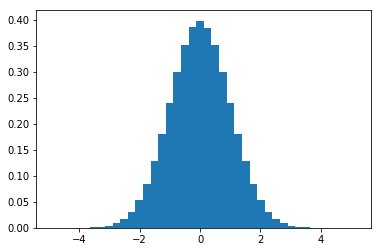

In [5]:
samples = np.random.normal(0, 1, 10000000)
count, bins, ignored = plt.hist(samples, 40, normed=True)
plt.show()

Now let's consider the expected value of various multinomial distributions. We will start with a special multinomial case where it's the same as a bernoulli distribution: the flip of a coin. 

In [6]:
flips = 3
coin = stat.multinomial(n=flips,p=[1/2]*2)

# The PMF of this function will look like this for two flips:
#    H   T
# H HH   HT
# T TH   TT
# 
# For three flips: 
#   HH  HT  TH  TT
# H HHH HTH THH THH
# T HHT HTT THT TTH

# Probability of a coin flipping heads/tails three times in a row. 
print("P(HHH) = {0:0.5f}".format(coin.pmf([3,0])))
print("P(TTT) = {0:0.5f}".format(coin.pmf([0,3])))

P(HHH) = 0.12500
P(TTT) = 0.12500


Now to compute the expected value of our bernoulli coin example, we need a way of enumerating all possible states that have a valid probability. This equates to permutations of a vector of size 2 ( which correspond to the number of head and tail flips) for a particular number of flips, each member of which much satisfy the following constraint:  

$$\large count(tails) + count(heads) = flips $$

We can do this in a combinatorial mannor with linear algebra as follows: 

In [7]:
# Sympy collapses the symetry of the matrix. ( I.e. in enumX(2,[H,T]) will show HT twic.
# It should show TH and HT, but this still works for our purposes.
def combX(nFlips,fundamentalVector):
    htm = sp.Matrix(fundamentalVector)
    r = htm
    if nFlips != 1:
        
        for i in range(nFlips-1):
            r = sp.Matrix(sp.flatten(r * htm.T))
        
    return r

# Gets rid of all duplicate entries.
def uniqueX(combX_r):
    hashDict = {}
    res = []
    for x_i in combX_r:
        if(str(x_i) not in hashDict):
            hashDict[str(x_i)] = 1
            res.append(x_i)
    return sp.Matrix(res)
        
# Takes in the unique permutations and translate them to numerical vectors. 
def enumX(unique_xs, mag):
    translationIdx = {"A":0,"B":1,"C":2,"D":3,"F":4,"G":5}
    out = []
    
    for xi in unique_xs:
        tmp = np.zeros(mag)
        prod = list(filter(None,str(xi).split("*")))
        
        for i in range(len(prod)):
            if(i + 1 < len(prod)):
                if(not prod[i].isdigit()):
                    if(prod[i+1].isdigit()):
                        tmp[translationIdx[prod[i]]] = int(prod[i+1])
                    else:
                        tmp[translationIdx[prod[i]]] = 1
            else:
                if(not prod[i].isdigit()):
                    tmp[translationIdx[prod[i]]] = 1
                    
        out.append(tmp)
        
    return out


# Converts expected value vector to expected value scalar. 
def expVToS(expV, nTrials):
    cntr = 1
    ev = 0 
    for i in expV:
        ev += cntr*(i/nTrials)
        cntr+=1
    return ev

Let's use these helper functions to enumerate the possible outcomes of flipping a coin 3 times. 

In [8]:
nFlips = 3
r = uniqueX(combX(nFlips,["A","B"]))
flipSpace = enumX(r,2)

Let's ensure that the probabilities of these combinations sum to one:

In [9]:
totalProb = 0 
for case in flipSpace:
    totalProb += coin.pmf( case )
    print(case)

print(totalProb)

[ 3.  0.]
[ 2.  1.]
[ 1.  2.]
[ 0.  3.]
1.0


In [10]:
ex = expect(coin.pmf,flipSpace)
print("Expected value per class: {0}".format(ex))
print("Expected value: {0}".format(expVToS(ex,3)) )

Expected value per class: [ 1.5  1.5]
Expected value: 1.5


As we see here, we expect half of the flips to land on heads and the other half on tails. In the expected value per class vector this is clear. When we convert the expected vector the the expected value we get 1.5 because we are encoding each side by an index 1 and 2 respectively. This is computed as follows: 

$$\large \frac{1}{nTrials/classExpectedFrequency} \frac{2}{nTrials/classExpectedFrequency} = \\ 1 * \frac{classExpectedFreq}{nTrials} + 2 * \frac{classExpectedFreq}{nTrials} = \frac{1}{2} + \frac{2}{2} = 1.5$$. 

We can show experimentally that the expected value for a coin flip will be 0.5 (half in each class): 

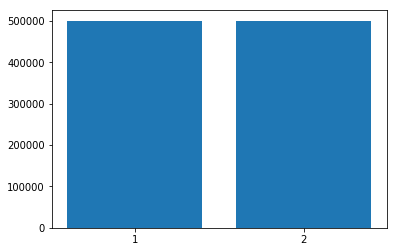

In [11]:
flips = 1000000
flipResults = np.random.multinomial(flips, [1/2]*2, size=1)[0]
plt.bar([1,2],flipResults)
plt.xticks([1,2])
plt.show()

Let's do the same thing for a six sided dice, where every side is labeled by letters A,B,C,D,F,G. **Note:** We do not use E because Sympy treats it as eluers number. My implementation is very hacky and is only meant for educational purposes. 

In [12]:
rolls = 6
dice = stat.multinomial(n=rolls,p=[1/6]*6)

print("P(ABCDFG) = {0:0.5f}".format(dice.pmf([1,1,1,1,1,1])))

P(ABCDFG) = 0.01543


In [13]:
# Let's enumerate the roll space and ensure all probabilities come to one. 
r = uniqueX(combX(6,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)

totalProb = 0
for roll in rollSpace:
    totalProb += dice.pmf(roll)

print("Total probability of roll space: {0:0.8f}.".format(totalProb))
print("Size of roll space: {0}".format(r.shape[0]))

Total probability of roll space: 1.00000000.
Size of roll space: 462


Enumerating the entire combinitorial becomes exponnential for larger numbers of trials and classes. Let's now compute the expected vector for a dice rolled 6 times. 

In [14]:
ex = expect(dice.pmf,rollSpace)
print("Expected value per face: {0}: ".format(ex))
print("Expected value: {0:4f}".format(expVToS(ex,rolls)))

Expected value per face: [ 1.  1.  1.  1.  1.  1.]: 
Expected value: 3.500000


Let's do one more example with a weighted dice that is biased towards one side, where sides 1 - 5 have a probability of 1/8 and side 6 has a probability of 3/8.

In [15]:
rolls = 6
biasedDice = stat.multinomial(n=rolls,p=[1/8,1/8,1/8,1/8,1/8,3/8])
r = uniqueX(combX(6,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)
ex = expect(biasedDice.pmf,rollSpace)
print("Expected value per face: {0}: ".format(ex))
print("Expected value: {0:4f}".format(expVToS(ex,rolls)))

Expected value per face: [ 0.75  0.75  0.75  0.75  0.75  2.25]: 
Expected value: 4.125000


As we can see, biasing the dice towards a higher number moves the expected value to a higher number. Let's change this so we bias the 1 on the dice instead of the 6. 

In [16]:
rolls = 6
biasedDice = stat.multinomial(n=rolls,p=[3/8,1/8,1/8,1/8,1/8,1/8])
r = uniqueX(combX(6,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)
ex = expect(biasedDice.pmf,rollSpace)
print("Expected value per face: {0}".format(ex))
print("Expected value: {0:4f}".format(expVToS(ex,rolls)))

Expected value per face: [ 2.25  0.75  0.75  0.75  0.75  0.75]
Expected value: 2.875000


## Variance & Standard Distribution

In [17]:
def var(xDistFn,xs=None,fn=(lambda x: x)):
    mean = expect(xDistFn,xs)
    z = lambda x: (fn(x)-mean)**2  
    return expect(xDistFn,xs,fn=z)

def std(xDistFn,xs=None,fn=(lambda x: x)):
    return np.sqrt(var(xDistFn,xs))


Let's begin with computing the variance of a normal distribution. 

In [18]:
normDist = stat.norm(loc=1,scale=0.1)
print("Variance: {0:5f}".format(normDist.var()))
print("Variance: {0:5f}".format(var(normDist.pdf)))


Variance: 0.010000
Variance: 0.010000


Now let's do the same for a biased dice versus an unbiased one.

In [19]:
# Unbiased. 
rolls = 6
dice = stat.multinomial(n=rolls,p=[1/6]*6)
r = uniqueX(combX(rolls,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)
print("Variance: {0}: ".format(expVToS(var(dice.pmf,rollSpace),rolls)))
print("Expected value: {0}".format(expVToS(expect(dice.pmf,rollSpace),rolls)))

Variance: 2.9166666666666634: 
Expected value: 3.4999999999999956


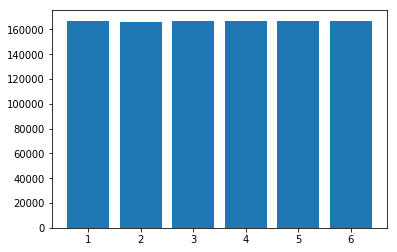

In [20]:
rolls = 1000000
rollResults = np.random.multinomial(rolls, [1/6]*6, size=1)[0]
plt.bar([1,2,3,4,5,6],rollResults)
plt.xticks([1,2,3,4,5,6])
plt.show()

In [21]:
rolls = 6
dice = stat.multinomial(n=rolls,p=[1/8,1/8,1/8,1/8,1/8,3/8])
r = uniqueX(combX(rolls,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)
print("Variance: {0}: ".format(expVToS(var(dice.pmf,rollSpace),rolls)))
print("Expected value: {0}".format(expVToS(expect(dice.pmf,rollSpace),rolls)))


Variance: 3.046875000000001: 
Expected value: 4.125000000000001


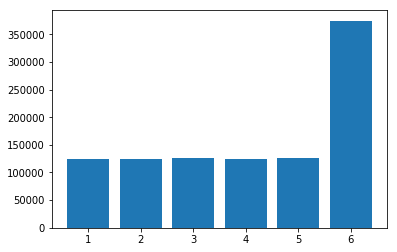

In [22]:
rolls = 1000000
rollResults = np.random.multinomial(rolls, [1/8,1/8,1/8,1/8,1/8,3/8], size=1)[0]
plt.bar([1,2,3,4,5,6],rollResults)
plt.xticks([1,2,3,4,5,6])
plt.show()

As we can see, the variance increases in biased dice example because the proabibilities are more varied,but not by much because we still have a lot of repitition. Let's create a really wacky dice that has different probabilities on each side. Do you think the variance will be larger?

In [23]:
rolls = 6
dice = stat.multinomial(n=rolls,p=[1/21,2/21,3/21,4/21,5/21,6/21])
r = uniqueX(combX(rolls,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)
print("Variance: {0}: ".format(expVToS(var(dice.pmf,rollSpace),rolls)))
print("Expected value: {0}".format(expVToS(expect(dice.pmf,rollSpace),rolls)))

Variance: 3.3333333333333357: 
Expected value: 4.3333333333333375


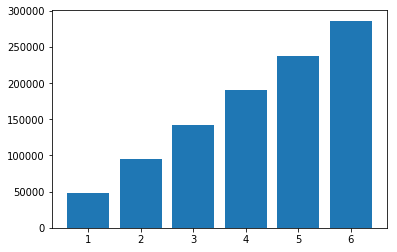

In [24]:
rolls = 1000000
rollResults = np.random.multinomial(rolls, [1/21,2/21,3/21,4/21,5/21,6/21], size=1)[0]
plt.bar([1,2,3,4,5,6],rollResults)
plt.xticks([1,2,3,4,5,6])
plt.show()

### Experimental Section
In this section we will try to find the probabilities of a set of weighted die faces that give us the largest variance with the constraint that no side can have a zero proability. The first part of this problem is figuring out a method of factoring 1 with 6 factors, 1 factor for each die face, with respect to some fundamental factor/precision. We require some fundamental precision/factor because any real number can be factored in an infinite number of ways. 


We can see that in the case of having two summands equal to 1, we produce a line in R2

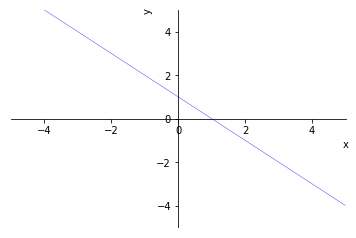

[-x + 1]

In [25]:
x = sp.symbols('x')
y = sp.symbols('y')
sp.plot_implicit(sp.Eq(x+y, 1))
a = sp.solve(sp.Eq(x+y, 1),y,implicit=True)
display(sp.solve(sp.Eq(x+y, 1),y,implicit=True))

On the interval x = [0,1], using the above formula y = -x + 1, we can calculate all sum permutations within a given precision governed by how fine our points are within this interval. 

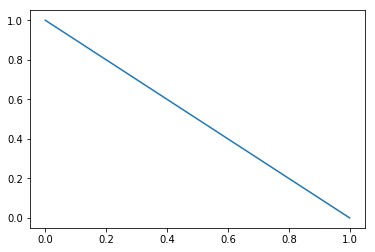

In [26]:
# [0,1] - 10 points on this interval
idx = np.linspace(0,1,10)
ys = []
for i in idx:
    ys.append(-i+1)
plt.plot(idx,ys)

plt.show()

In [27]:
for i in zip(idx,ys):
    print("{0:4f} + {1:4f} = {2}".format(i[0],i[1],i[0]+i[1]))

0.000000 + 1.000000 = 1.0
0.111111 + 0.888889 = 1.0
0.222222 + 0.777778 = 1.0
0.333333 + 0.666667 = 1.0
0.444444 + 0.555556 = 1.0
0.555556 + 0.444444 = 1.0
0.666667 + 0.333333 = 1.0
0.777778 + 0.222222 = 1.0
0.888889 + 0.111111 = 1.0
1.000000 + 0.000000 = 1.0


If we add more points in the linear subspace between [0,1], we will get finer combinations. Now what about the case of representing 1 as three summands:

In [38]:
x1,x2,x3,Z = sp.symbols('x1 x2 x3 Z')
# in the case of three variables 
sp.solve(sp.Eq(x+y+z, 1),y,implicit=True)

NameError: name 'z' is not defined

The general form seems to be:
$$\large -x_1 - x_2 - ... - x_{n-1} + Z = x_n$$
Where the x's are the variables representing the summands and the Z is the number we'd like to sum to.
For the case of three variables, we have the system of equations: 
$$\large -x_1 - x_2 + Z = x_3 \\\large -x_1 - x_3 + Z = x_2 \\\large -x_2 - x_3 + Z = x_1$$
Let's define a python function to do this for us.

In [39]:
x1,x2,x3,Z = sp.symbols('x1 x2 x3 Z')
eqn = []
eqn.append(sp.Eq(-x1 - x2 + Z, x3))
eqn.append(sp.Eq(-x1 - x3 + Z, x2))
eqn.append(sp.Eq(-x2 - x3 + Z, x1))
sp.solve(eqn,x1)

{x₁: Z - x₂ - x₃}

The eloquent way of solving this requires a notion of cycling a vector with modulo. We define the following function to help us do this: 

In [31]:
def cycleDown(vect, times=1):
    vCpy = list(vect)
    for i in range(times):
        vCpy.insert(0,vCpy[-1])
        vCpy.pop()
    return vCpy
    
ls = [0,1,2,3]
print(ls)
for i in range(10):
    ls = cycleDown(ls)
    print(ls)

[0, 1, 2, 3]
[3, 0, 1, 2]
[2, 3, 0, 1]
[1, 2, 3, 0]
[0, 1, 2, 3]
[3, 0, 1, 2]
[2, 3, 0, 1]
[1, 2, 3, 0]
[0, 1, 2, 3]
[3, 0, 1, 2]
[2, 3, 0, 1]


We will now produce a linear subspace and stack it however many terms is required, then we will cycle the lists until they sum to one across all rows. 

In [32]:
def summandsPermute(val,nTerms,precision=10):
    
    outLs = []
    idx = np.linspace(0,val,precision)
    
    # Remove edge cases. 
    idx = idx[1:-1]
    
    cycleVal = nTerms
    cycleCounter = 0
    for i in range(nTerms):
        outLs.append(list(cycleDown(idx,cycleCounter)))
        cycleCounter+=cycleVal
        
    
    return list(zip(*outLs))

result = summandsPermute(1,3)
for i in result:
    print(i)
    
print(len(result))


(0.1111111111111111, 0.66666666666666663, 0.33333333333333331)
(0.22222222222222221, 0.77777777777777768, 0.44444444444444442)
(0.33333333333333331, 0.88888888888888884, 0.55555555555555558)
(0.44444444444444442, 0.1111111111111111, 0.66666666666666663)
(0.55555555555555558, 0.22222222222222221, 0.77777777777777768)
(0.66666666666666663, 0.33333333333333331, 0.88888888888888884)
(0.77777777777777768, 0.44444444444444442, 0.1111111111111111)
(0.88888888888888884, 0.55555555555555558, 0.22222222222222221)
8


In [78]:
def sumTop(ls):
    sumLs = 0
    for i in ls:
        sumLs += i[0]
    return sumLs
def cycleColumn(group,index):
    group[index] = cycleDown(group[index])

def summandsPermute(val,nTerms,precision=10):
    
    outLs = []
    cycleGroup = []
    idx = np.linspace(0,val,precision)
    
    # Remove edge cases. 
    idx = idx[1:-1]
    
    for i in range(nTerms):
        cycleGroup.append(list(idx))
    
    cycleIndex = nTerms - 1
    
    for i in range(4):
        res = sum(list(zip(*cycleGroup))[0])
        print(res)
        if(res==1):
            print("Ayy")
        else:
            cycleColumn(cycleGroup,cycleIndex)
        
    
    return list(zip(*outLs))

result = summandsPermute(1,3)


0.333333333333
1.11111111111
1.0
0.888888888889


In [29]:

0.111111111111111 + 0.1111111111111111 + 0.777777777777777
0.111111111111111 + 0.2222222222222222 + 0.6666666666
0.111111111111111 + 0.33333333333333 +  0.5555555555555

0.9999999999999991

In [33]:
0.111111111111111 + 0.2222222222222222 + 0.6666666666

0.9999999999333331

In [36]:
0.111111111111111 + 0.33333333333333 +  0.5555555555555

0.9999999999999409

In [ ]:
def varOfMulti(p,rs,r):
    d = stat.multinomial(n=r,p=p)
    return expVToS(var(d.pmf,rs),r)

rolls = 6
r = uniqueX(combX(rolls,["A","B","C","D","F","G"]))
rollSpace = enumX(r,6)

In [ ]:
#varOfMulti([2/10,2/10,1/10,1/10,3/10,1/10],rollSpace,rolls)
factorize(1,3)

## Covariance

In [ ]:
1/3 - 1/10 - 1/10

In [ ]:
1/10